# Uniswap + perpetual contract

用永续合约对冲Impermanent Loss


@ version2.0 静态delta hedge

**字段释疑 ： p是现价，p_0是开仓价或者add liquidity时的dexprice，liquidity是我们加入的liquidity**

Uniswap的币变动由以下公式给出：

$$
dx = liq \times (\frac{1}{\sqrt{p}} - \frac{1}{\sqrt{p_0}})
$$

同时，合约的损益为：

$$
PnL = (\frac{1}{p_0} - \frac{1}{p}) * n_{value}
$$

$n_{value}$ 是合约名义价值，即当杠杆为2x，nomination为1000usdt时，合约实际的名义价值为2 * 1000 usdt。

因此要使得合约的损益对冲，需要满足：

$$
totalPnL = Pnl + dx = liq \times (\frac{1}{\sqrt{p}} - \frac{1}{\sqrt{p_0}}) + (\frac{1}{p_0} - \frac{1}{p}) * n_{value}
$$

**由上totalPnL看出来，当p1接近于p0时，totalPnL近似稳定，但当p1偏移时不能保持稳定，因此需要动态调整头寸价值$n_{value} = a(p_1)$,即头寸关于现价p1变动**


@ version2.1

Cswaps

$$
\begin{cases}
\frac{d(dx)}{dp} = -0.5 \times Lp^{-1.5} \\
\frac{db}{dp} = ap^{-2}
\end{cases}
$$
解得$a = liq\sqrt{p} / 2 $

Uswaps

$$
\begin{cases}
\frac{dy}{dp} = 0.5 \times Lp^{-0.5}\\
\frac{du}{dp} = \frac{a}{p_0}
\end{cases}
$$
解得$a = \frac{liq\times p_0}{2\sqrt{p}} = liq\sqrt{p} / 2$

**如果我们忽略Divident，将UniLP的头寸变化量记为净损益$dx，dy$，可以看到二者的delta是关于$p^{-{0.5}},p^{-1.5}$的函数，而期货的delta是关于对冲数量$a$的函数。只有动态调整$a$，才能达到delta  hedge的目的。
此时, 可能会涉及到手续费和总损失（dx + dy + bipnl + upnl）之间的抉择。**





调整方法，在价格偏移达到给定sigma时，币本位追加头寸$\Delta a = liq\sqrt{p_t} / 2 - liq\sqrt{p_{t-1}} / 2 $


**通过动态调整头寸量，让总敞口关于价格的导数在调整的一瞬间为0。此之谓动态对冲。结果参照2.3**

# 双合约对冲的结论

## sigma=0.05
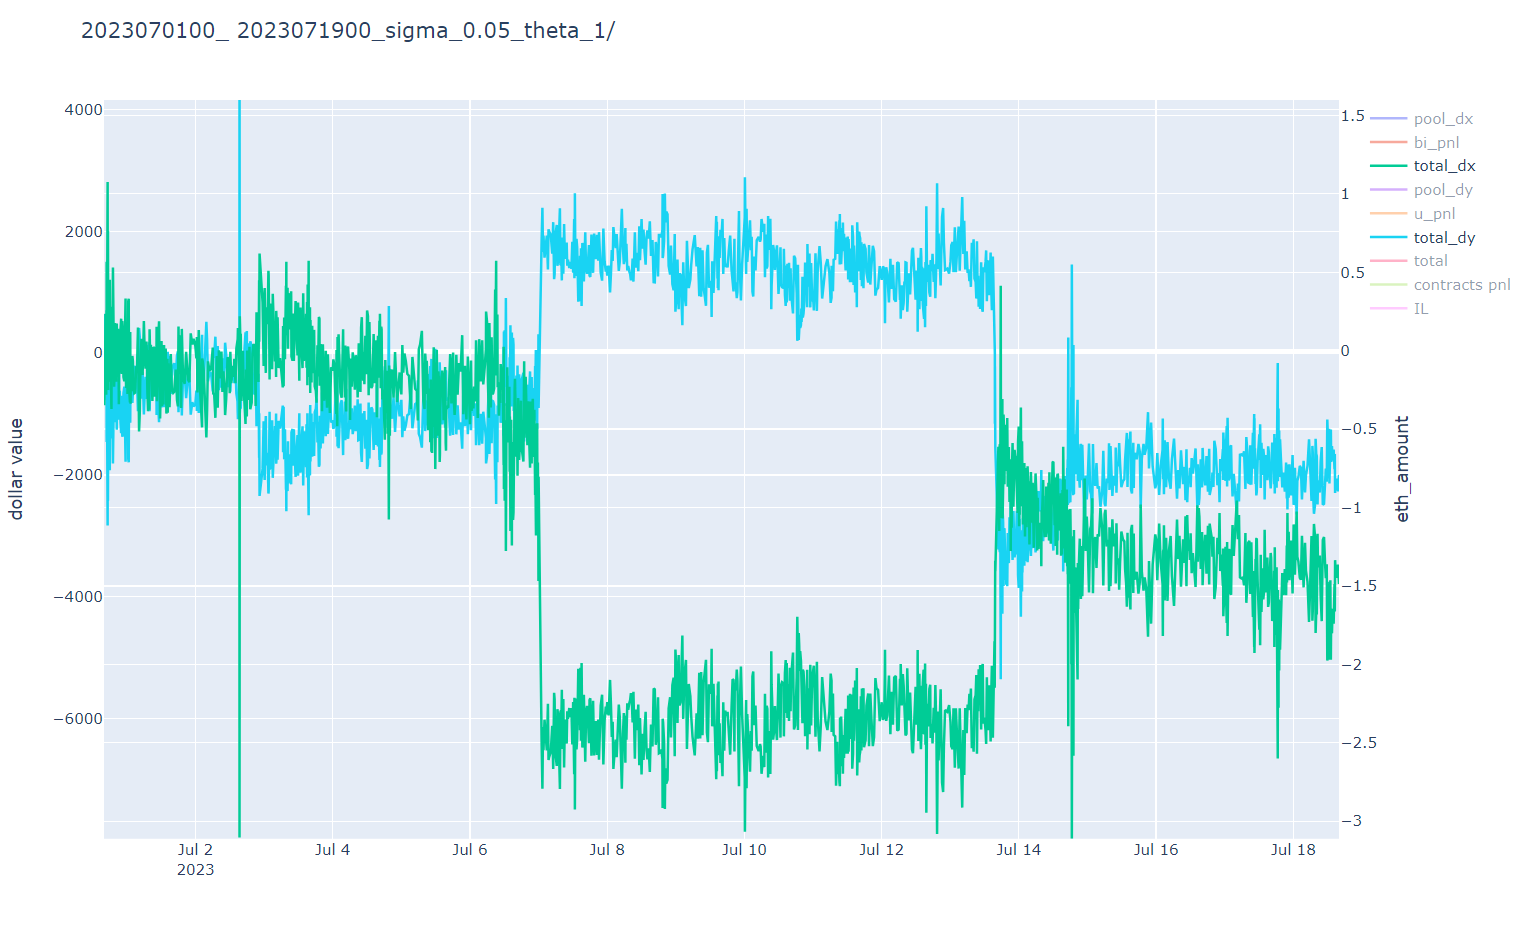
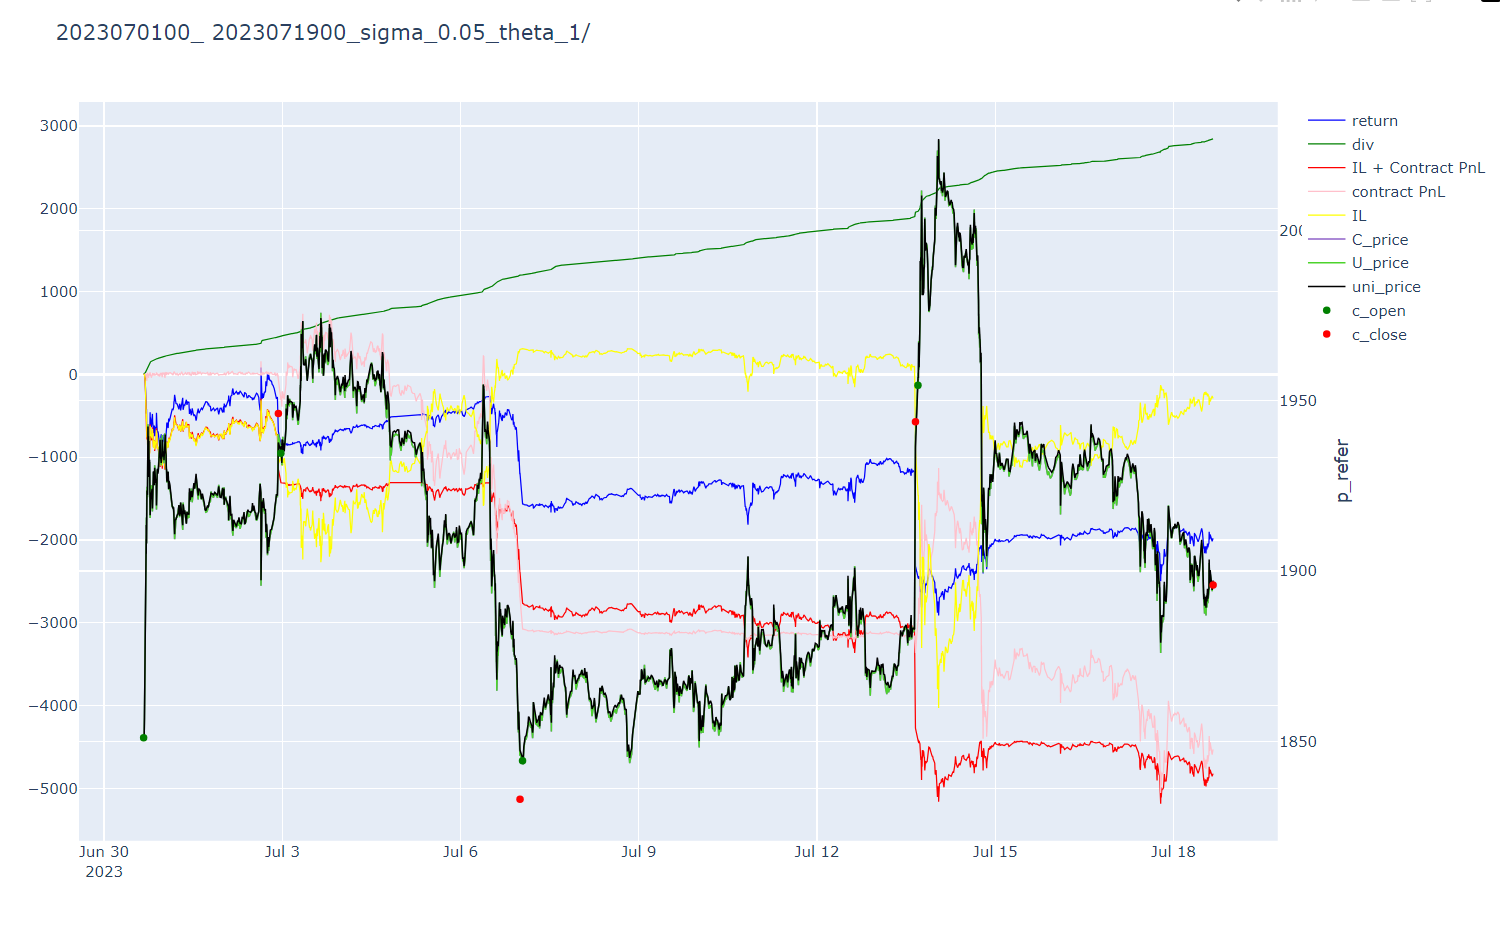

从eth的敞口图看，突变处为撤出那一刻，总体的eth数量和usdt数量在一个pool中比较稳定。

从收益曲线图来看，当价格稳定时表现较好，而短时间内价格上升和下降，都会造成较大回撤。这是因为合约的收益变动是随价格一次方变化的，而IL是和价格的平方根变化的。

## sigma = 0.08

当sigma增大时，十天内则没有撤出，可见eth的总变化量（即uni实时失去的eth + 币本位永续合约实时的盈利）基本保持在0上下，usdt的变化量亦是如此。

**神奇的是，这次的收益曲线和没有对冲的收益曲线基本重合，为什么？**

- 这是很好理解的，由于两个合约的头寸大小相同，方向相反，因此合约的净损益是0，而uni资产的损益是IL，资产的损益就是$合约净损益 + IL + div。$
- 对冲和不对冲的差别是，在结束的时候我是持有50% + 50%的eth/usdc，还是持有单边的eth或者usdc。
- 损失的根本原因，是期货线性损益和uni非线性损益之间的误差。


**此策略收益等效于以下策略：
在remove时在现货市场平敞口 —— 比如，当remove时我的pool变成了 （25-12）：（50000 + 25000），则在现货市场以现价买12个eth。**

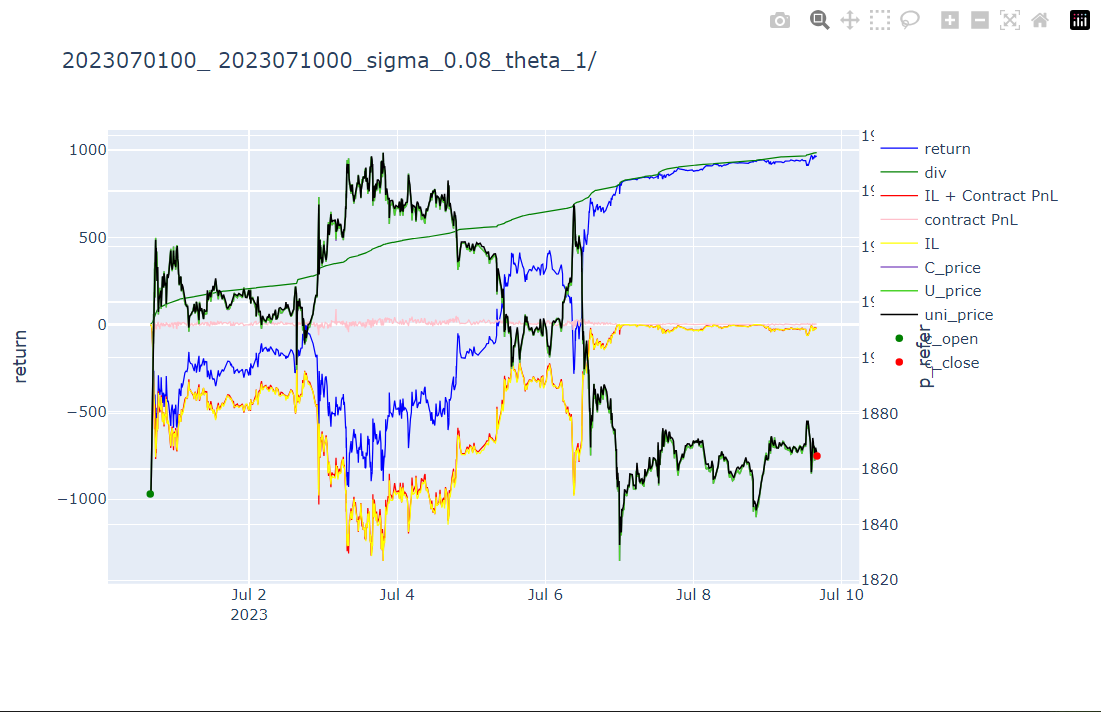
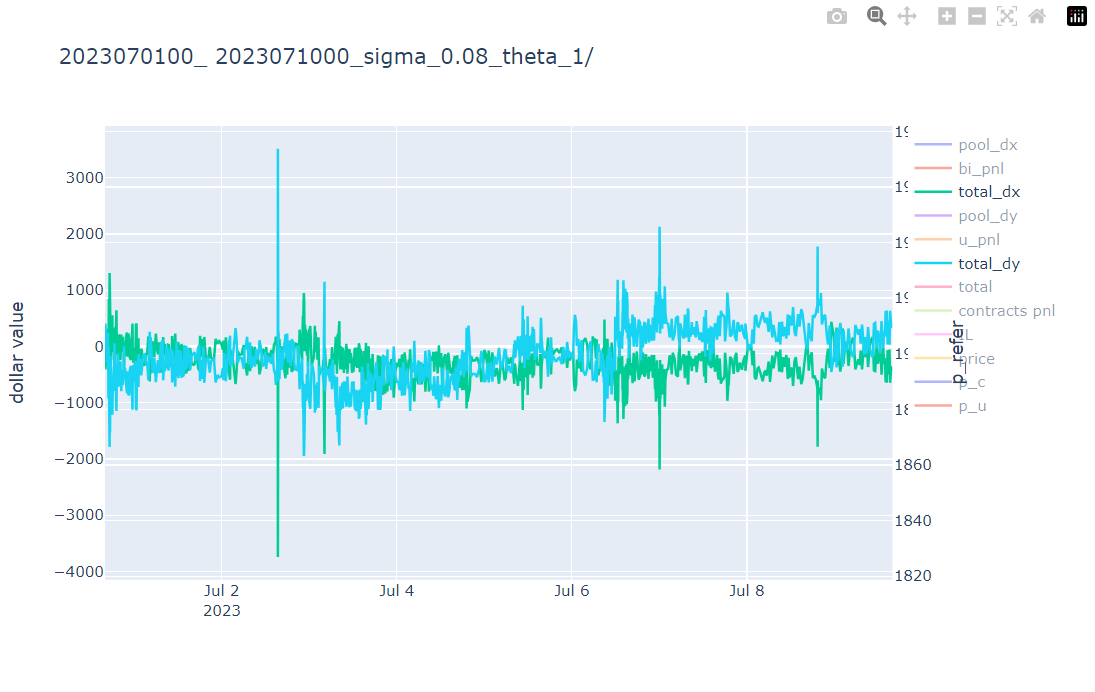



## 在pool中调整头寸数量

需要有个概念的是，pool中调整的头寸数量相比于仓位十分小，100万美元的仓位，每次调整的数量大概是2000~5000美元左右（取决于调整阈值）。

从趋势上来看，调仓的必要性也许不大。

**同2.1中叙述，此策略等效于：当观察到价格偏移theta，在现货市场买回或者卖出对应的敞口。**
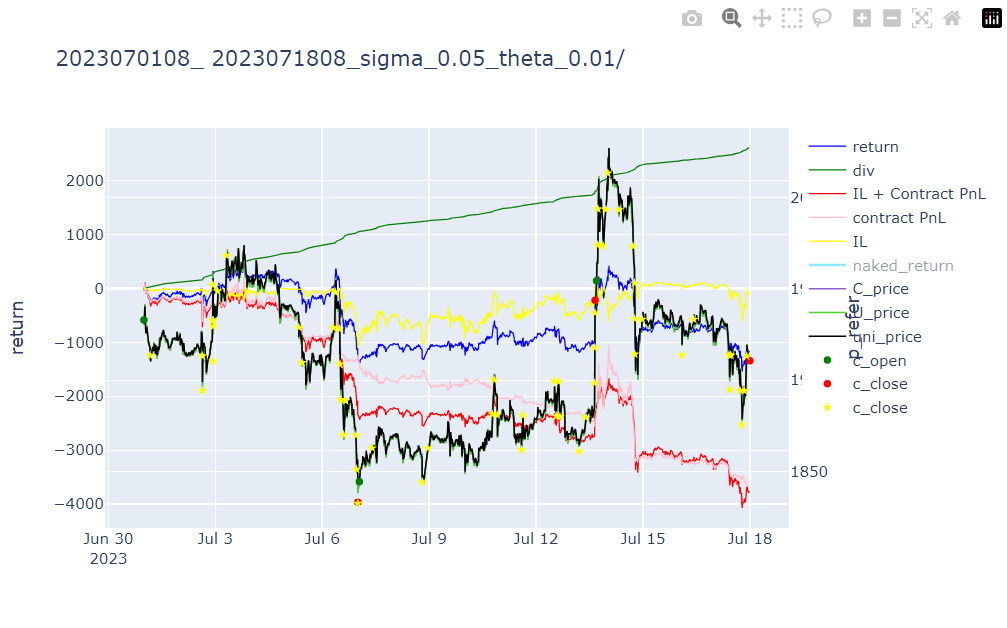
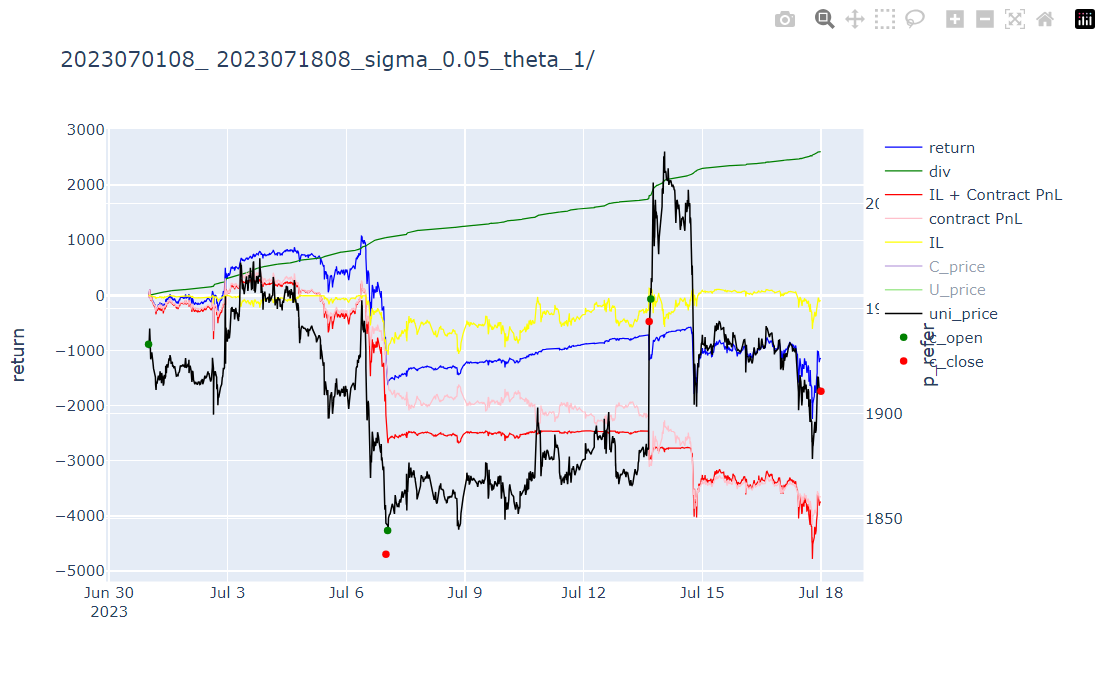